In [31]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [32]:
rebap_saldo = (pl.read_excel("data/rebap_imb_202401.xlsx",)
               .select("Datetime", "reBAP", "RZ-Saldo")
               .rename({"Datetime": "datetime",
                        "reBAP": "rebap",
                        "RZ-Saldo": "saldo"})
               .with_columns(
    pl.col("datetime").str.to_datetime()
))

da = (pl.scan_csv("data/epex_spot_h_202401.csv", separator=";", decimal_comma=True)
      .select("Datum von", "Deutschland/Luxemburg [€/MWh] Originalauflösungen")
      .rename({"Datum von": "datetime",
               "Deutschland/Luxemburg [€/MWh] Originalauflösungen": "da_price"})
      .with_columns(
    pl.col("datetime").str.to_datetime()
)
      .collect())

data = rebap_saldo.join(
    da, on="datetime", how="left",
).with_columns(
    pl.col("da_price").forward_fill()
)

In [33]:
data = data.with_columns(
    (pl.col("rebap") - pl.col("da_price")).alias("spread")
)

In [34]:
plot_df = data.group_by(pl.col("datetime").dt.strftime("%H:%M").alias("sp")).agg(
    pl.col("spread").mean(),
    pl.col("saldo").mean()
).sort("sp")

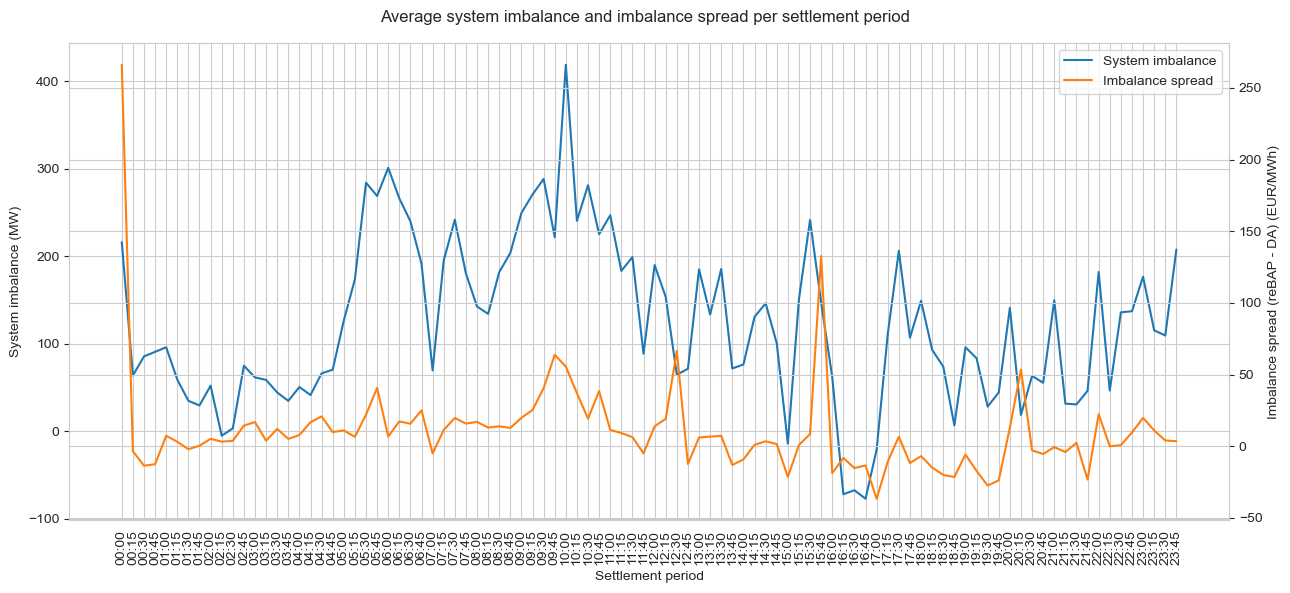

In [55]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(plot_df.select("sp").to_numpy().flatten(), 
        plot_df.select("saldo").to_numpy().flatten(), label="System imbalance", color="#1f77b4")

labels = plot_df.select("sp").to_series().to_list()
ax.set_xticks(labels)
ax.set_xticklabels(labels, rotation=90)

ax_2 = ax.twinx()
ax_2.plot(plot_df.select("sp").to_numpy().flatten(), 
          plot_df.select("spread").to_numpy().flatten(), label="Imbalance spread", color="#ff7f0e")

ax.set_xlabel("Settlement period")
ax.set_ylabel("System imbalance (MW)")
ax_2.set_ylabel("Imbalance spread (reBAP - DA) (EUR/MWh)")

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax_2.get_legend_handles_labels()
ax_2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

fig.suptitle("Average system imbalance and imbalance spread per settlement period")

plt.tight_layout()
plt.show()

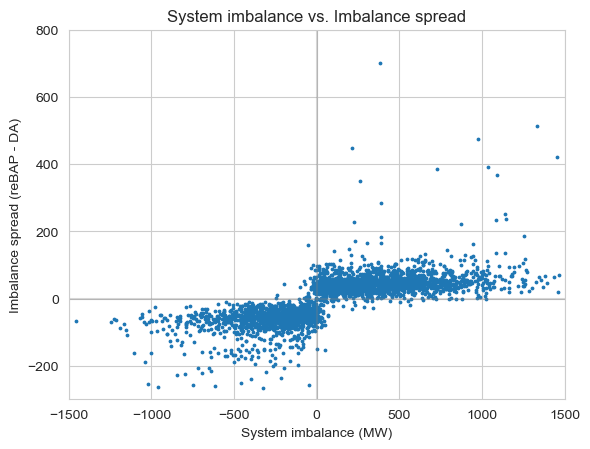

In [57]:
plt.figure()

plt.scatter(data.select("saldo"), data.select("spread"), s=3)

xlim = [-1500, 1500]
ylim = [-300, 800]
plt.hlines(y=0, color="grey", xmin=xlim[0], xmax=xlim[1], alpha=0.3)
plt.vlines(x=0, color="grey", ymin=ylim[0], ymax=ylim[1], alpha=0.3)
plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel("System imbalance (MW)")
plt.ylabel("Imbalance spread (reBAP - DA)")
plt.title("System imbalance vs. Imbalance spread")

plt.show()

In [49]:
data.select(pl.col("saldo", "spread")).corr()

saldo,spread
f64,f64
1.0,0.346722
0.346722,1.0
